In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arukalavinay","key":"0636053e1c1dd40510389e5c47c24d2f"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Replace with your dataset identifier
!kaggle datasets download -d amaldev007/driver-drowsiness-detection-system-dataset
!unzip -q driver-drowsiness-detection-system-dataset.zip -d data/


Dataset URL: https://www.kaggle.com/datasets/amaldev007/driver-drowsiness-detection-system-dataset
License(s): unknown


In [3]:
import os, shutil
from sklearn.model_selection import train_test_split

base_dir = '/content/data/0 FaceImages'
drowsy_dir = os.path.join(base_dir, 'Fatigue Subjects')
non_drowsy_dir = os.path.join(base_dir, 'Active Subjects')

output_base = '/content/organized_data'
train_dir = os.path.join(output_base, 'train')
val_dir = os.path.join(output_base, 'val')
test_dir = os.path.join(output_base, 'test')

for split in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(split, 'Fatigue Subjects'), exist_ok=True)
    os.makedirs(os.path.join(split, 'Active Subjects'), exist_ok=True)

def split_and_copy(class_dir, label):
    files = os.listdir(class_dir)
    train_files, testval_files = train_test_split(files, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(testval_files, test_size=0.5, random_state=42)

    for f in train_files:
        shutil.copy(os.path.join(class_dir, f), os.path.join(train_dir, label, f))
    for f in val_files:
        shutil.copy(os.path.join(class_dir, f), os.path.join(val_dir, label, f))
    for f in test_files:
        shutil.copy(os.path.join(class_dir, f), os.path.join(test_dir, label, f))

split_and_copy(drowsy_dir, 'Fatigue Subjects')
split_and_copy(non_drowsy_dir, 'Active Subjects')


In [4]:
import os
import shutil

def restructure_to_sequences(root_dir, seq_len=10):
    for split in ['train', 'val', 'test']:
        for label in ['Fatigue Subjects', 'Active Subjects']:
            input_path = os.path.join(root_dir, split, label)
            output_path = os.path.join(root_dir + '_sequence', split, label)
            os.makedirs(output_path, exist_ok=True)

            images = sorted([img for img in os.listdir(input_path) if img.endswith(('.jpg', '.png'))])
            total_clips = len(images) // seq_len

            for i in range(total_clips):
                clip_dir = os.path.join(output_path, f'clip_{i}')
                os.makedirs(clip_dir, exist_ok=True)
                for j in range(seq_len):
                    src = os.path.join(input_path, images[i * seq_len + j])
                    dst = os.path.join(clip_dir, f'frame_{j:02d}.jpg')
                    shutil.copy2(src, dst)

            print(f"[{split}/{label}] -> {total_clips} clips created.")

# Update path to your base dataset folder
restructure_to_sequences('/content/organized_data', seq_len=10)


[train/Fatigue Subjects] -> 319 clips created.
[train/Active Subjects] -> 319 clips created.
[val/Fatigue Subjects] -> 68 clips created.
[val/Active Subjects] -> 68 clips created.
[test/Fatigue Subjects] -> 68 clips created.
[test/Active Subjects] -> 68 clips created.


In [5]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random

class SequenceGenerator(Sequence):
    def __init__(self, directory, batch_size, img_size, sequence_length, shuffle=True):
        self.batch_size = batch_size
        self.img_size = img_size
        self.sequence_length = sequence_length
        self.shuffle = shuffle
        self.samples = []
        self.labels = []

        class_indices = {'Fatigue Subjects': 1, 'Active Subjects': 0}
        for label in ['Fatigue Subjects', 'Active Subjects']:
            class_dir = os.path.join(directory, label)
            for clip in os.listdir(class_dir):
                clip_path = os.path.join(class_dir, clip)
                if os.path.isdir(clip_path):
                    frames = sorted(os.listdir(clip_path))[:sequence_length]
                    if len(frames) == sequence_length:
                        self.samples.append([os.path.join(clip_path, f) for f in frames])
                        self.labels.append(class_indices[label])

        self.indices = np.arange(len(self.samples))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.samples) // self.batch_size

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_x = []
        batch_y = []

        for i in batch_indices:
            frames = []
            for frame_path in self.samples[i]:
                img = load_img(frame_path, target_size=(self.img_size, self.img_size))
                img = img_to_array(img) / 255.0
                frames.append(img)
            batch_x.append(frames)
            batch_y.append(self.labels[i])

        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


In [6]:
import os
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.layers import (TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense,
                                     Dropout, BatchNormalization, GlobalAveragePooling2D, Input)
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

# ====== CONFIGURATION ======
DATASET_DIR = '/content/organized_data_sequence'
IMG_SIZE = (128, 128)
SEQUENCE_LENGTH = 5
BATCH_SIZE = 4
EPOCHS = 5
label_map = {'Fatigue Subjects': 1, 'Active Subjects': 0}

# ====== DATA GENERATOR ======
class ClipSequenceGenerator(Sequence):
    def __init__(self, base_dir, label_map, split='train', batch_size=8, img_size=(64, 64), seq_len=10, shuffle=True):
        self.split_dir = os.path.join(base_dir, split)
        self.label_map = label_map
        self.batch_size = batch_size
        self.img_size = img_size
        self.seq_len = seq_len
        self.shuffle = shuffle
        self.samples = self._collect_samples()
        self.on_epoch_end()

    def _collect_samples(self):
        samples = []
        for label in self.label_map.keys():
            class_path = os.path.join(self.split_dir, label)
            for clip in os.listdir(class_path):
                clip_path = os.path.join(class_path, clip)
                frames = sorted(os.listdir(clip_path))
                if len(frames) >= self.seq_len:
                    samples.append((clip_path, label))
        return samples

    def __len__(self):
        return len(self.samples) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.samples)

    def __getitem__(self, idx):
        batch = self.samples[idx * self.batch_size: (idx + 1) * self.batch_size]
        X, y = [], []
        for clip_path, label in batch:
            frames = sorted(os.listdir(clip_path))[:self.seq_len]
            sequence = []
            for frame in frames:
                img_path = os.path.join(clip_path, frame)
                img = load_img(img_path, target_size=self.img_size)
                img = img_to_array(img) / 255.0
                sequence.append(img)
            X.append(sequence)
            y.append(self.label_map[label])
        return np.array(X), np.array(y)

# ====== GENERATORS ======
train_gen = ClipSequenceGenerator(DATASET_DIR, label_map, split='train', batch_size=BATCH_SIZE, img_size=IMG_SIZE, seq_len=SEQUENCE_LENGTH)
val_gen = ClipSequenceGenerator(DATASET_DIR, label_map, split='val', batch_size=BATCH_SIZE, img_size=IMG_SIZE, seq_len=SEQUENCE_LENGTH)
test_gen = ClipSequenceGenerator(DATASET_DIR, label_map, split='test', batch_size=BATCH_SIZE, img_size=IMG_SIZE, seq_len=SEQUENCE_LENGTH)

# ====== LIGHTWEIGHT CNN-LSTM MODEL ======
model = Sequential([
    TimeDistributed(Conv2D(8, (3, 3), activation='relu', padding='same'),
                    input_shape=(SEQUENCE_LENGTH, IMG_SIZE[0], IMG_SIZE[1], 3)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2, 2))),

    TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2, 2))),

    TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2, 2))),

    TimeDistributed(GlobalAveragePooling2D()),

    LSTM(16, return_sequences=False),
    Dropout(0.3),

    Dense(8, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# ====== TRAIN ======
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history=model.fit(train_gen,
          validation_data=val_gen,
          epochs=EPOCHS,
          callbacks=[early_stop])

# ====== EVALUATE ======
loss, acc = model.evaluate(test_gen)
print(f"\n✅ Test Accuracy: {acc * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 5, 128, 128, 8) │           224 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 5, 128, 128, 8) │            32 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 5, 64, 64, 8)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 5, 64, 64, 16)  │         1,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 5, 64, 64, 16)  │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 5, 32, 32, 16)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 5, 32, 32, 32)  │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 5, 32, 32, 32)  │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 5, 16, 16, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 5, 32)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,537 (37.25 KB)

 Trainable params: 9,425 (36.82 KB)

 Non-trainable params: 112 (448.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 55s 272ms/step - accuracy: 0.5189 - loss: 0.6990 - val_accuracy: 0.7426 - val_loss: 0.6210
Epoch 2/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 76s 261ms/step - accuracy: 0.6262 - loss: 0.6591 - val_accuracy: 0.7574 - val_loss: 0.5826
Epoch 3/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 77s 231ms/step - accuracy: 0.6628 - loss: 0.6328 - val_accuracy: 0.7574 - val_loss: 0.5511
Epoch 4/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 231ms/step - accuracy: 0.7173 - loss: 0.5772 - val_accuracy: 0.7574 - val_loss: 0.5364
Epoch 5/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 40s 253ms/step - accuracy: 0.7185 - loss: 0.5861 - val_accuracy: 0.7794 - val_loss: 0.5347
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.8435 - loss: 0.4938

✅ Test Accuracy: 82.35%


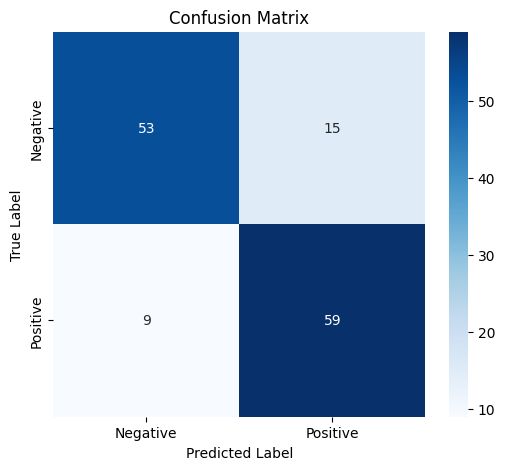


Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.78      0.82        68
           1       0.80      0.87      0.83        68

    accuracy                           0.82       136
   macro avg       0.83      0.82      0.82       136
weighted avg       0.83      0.82      0.82       136



In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_true = []
y_pred = []

# Predict using the generator
for i in range(len(test_gen)):
    X_batch, y_batch = test_gen[i]
    preds = model.predict(X_batch, verbose=0)
    preds_binary = (preds > 0.5).astype(int).flatten()

    y_true.extend(y_batch)
    y_pred.extend(preds_binary)

y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred))


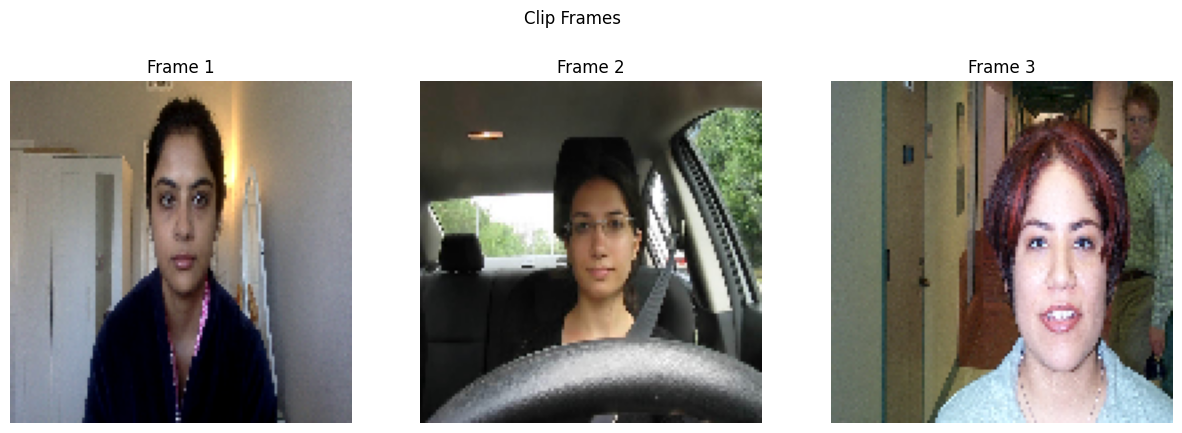

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
🔍 Prediction: Non Drowsy 🚗 (Confidence: 0.53)
Label: Non Drowsy 🚗
Score: 0.5308505


In [13]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import numpy as np

# Updated predict_clip function
def predict_clip(clip_path, model, seq_len=3, img_size=(128, 128)):
    valid_ext = ('.jpg', '.jpeg', '.png')  # Allow only image files
    frames = sorted([f for f in os.listdir(clip_path)
                     if f.lower().endswith(valid_ext) and not f.startswith('.')])[:seq_len]

    if len(frames) < seq_len:
        raise ValueError(f"❌ Need at least {seq_len} image frames, found {len(frames)}")

    sequence = []
    plt.figure(figsize=(15, 5))

    for i, frame in enumerate(frames):
        img_path = os.path.join(clip_path, frame)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0
        sequence.append(img_array)

        # Show the image
        plt.subplot(1, seq_len, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Frame {i+1}")

    plt.suptitle("Clip Frames")
    plt.show()

    X = np.expand_dims(sequence, axis=0)  # Shape: (1, seq_len, H, W, 3)
    prediction = model.predict(X)[0][0]
    label = "Drowsy 💤" if prediction > 0.5 else "Non Drowsy 🚗"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    print(f"🔍 Prediction: {label} (Confidence: {confidence:.2f})")
    return label, confidence

# Example usage
clip_path = "/content/organized_data_sequence/test/Active Subjects/clip_0"
label, confidence = predict_clip(clip_path, model)
print("Label:", label)
print("Score:", confidence)


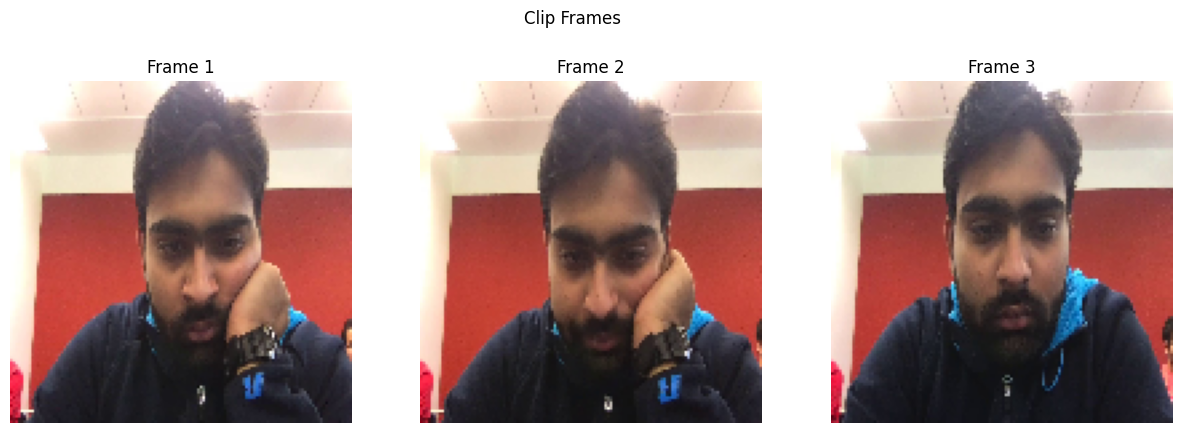

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
🔍 Prediction: Drowsy 💤 (Confidence: 0.68)
Label: Drowsy 💤
Score: 0.6831285


In [14]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import numpy as np

# Updated predict_clip function
def predict_clip(clip_path, model, seq_len=3, img_size=(128, 128)):
    valid_ext = ('.jpg', '.jpeg', '.png')  # Allow only image files
    frames = sorted([f for f in os.listdir(clip_path)
                     if f.lower().endswith(valid_ext) and not f.startswith('.')])[:seq_len]

    if len(frames) < seq_len:
        raise ValueError(f"❌ Need at least {seq_len} image frames, found {len(frames)}")

    sequence = []
    plt.figure(figsize=(15, 5))

    for i, frame in enumerate(frames):
        img_path = os.path.join(clip_path, frame)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0
        sequence.append(img_array)

        # Show the image
        plt.subplot(1, seq_len, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Frame {i+1}")

    plt.suptitle("Clip Frames")
    plt.show()

    X = np.expand_dims(sequence, axis=0)  # Shape: (1, seq_len, H, W, 3)
    prediction = model.predict(X)[0][0]
    label = "Drowsy 💤" if prediction > 0.5 else "Non Drowsy 🚗"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    print(f"🔍 Prediction: {label} (Confidence: {confidence:.2f})")
    return label, confidence

# Example usage
clip_path = "/content/organized_data_sequence/test/Fatigue Subjects/clip_44"
label, confidence = predict_clip(clip_path, model)
print("Label:", label)
print("Score:", confidence)


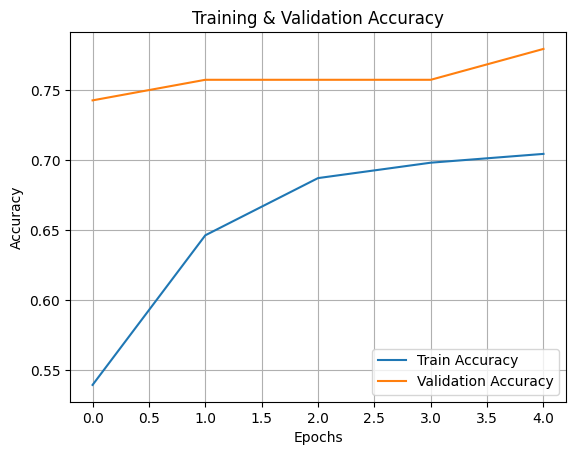

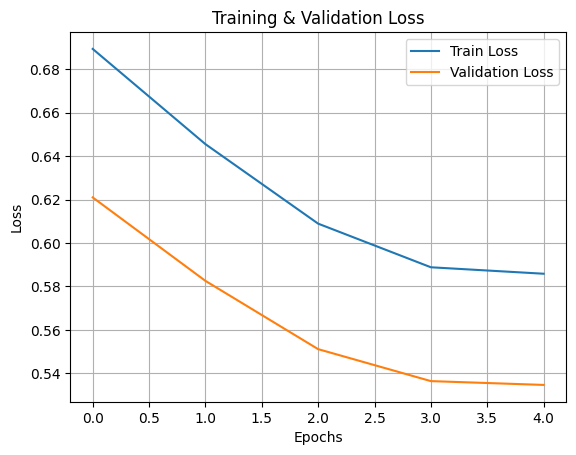

In [15]:
# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()